In [4]:
import os
import sys
import operator
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor
from sklearn import model_selection, preprocessing, ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import hashlib
import re
from sklearn.model_selection import GridSearchCV,StratifiedKFold

#from sklearn.preprocessing import LabelEncoder

/home/jianqi/anaconda2/envs/xgboost/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# On Column 'features' -- cleaning, transforming

In [5]:
def text_fea(df1_,df2_,nTop=300,combine=True):
    ''' df1_ is training set
        df2_ is test set
    '''
    from collections import defaultdict
    df1 = df1_.copy() # Maybe ther eis better way to avoid SettingWithCopyWarning 
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    #df['features'] = df['features'].map(lambda x:[tt.lower() for tt in x])
    df['description'] = df['description'].map(lambda x:x.lower())
    #---------------------------
    #original length of the first feature, meant to capture those features typed in with wrong 
    # format -- all features are cramed into one phrase
    df['len_feature0'] = df['features'].map(lambda x:0 if len(x)==0 else len(x[0])) 
    #-----------------------------
    
    def fea_clean(x): 
        if len(x) == 1:
            tmp = x[0].strip('*').split('*')
            if len(tmp) ==1:
                tmp = tmp[0].split(u'\u2022')
            x = tmp
        ret = [tt.encode('utf-8').decode('unicode_escape').encode('ascii','ignore').lower().strip() for tt in x]
        return ret
    df['features'] = df['features'].map(fea_clean)
    
    
    all_fea = defaultdict(int)
    for _,row in df.iterrows():
        for xx in row['features']:
            all_fea[xx] += 1
    sorted_fea = sorted(all_fea.iteritems(),key=lambda (k,v): v,reverse=True)
    
    combined_fea = {'laundry in unit':['laundry in unit','in-unit washer/dryer','washer & dryer',
                                        'washer/dryer','washer/dryer in unit'],
                   'laundry in building':['laundry in building','laundry room',
                                           'washer/dryer in building','on-site laundry'],
                   'gym/fitness':['gym/fitness','fitness center','gym','gym in building'],
                   'pre-war':['pre-war','prewar'],
                    'live-in superintendent':['live-in superintendent','live-in super','live in super'],
                    'hardwood floors':['hardwood floors','hardwood','hardwood floor','hardwood flooring'],
                    'high ceiling':['high ceiling','high ceilings'],
                    'full-time doorman':['full-time doorman','ft doorman','24/7 doorman','24 hour doorman',
                                        '24-hour doorman','24hr doorman','full time doorman','24 hr doorman']
                   #'garage':['garage','parking']
                   }
    
    fea_list = set([v[0] for v in sorted_fea[:nTop]])
    for k,v in combined_fea.iteritems():
        fea_list = fea_list.union(set(v))
    for fea in fea_list:
        df[fea] = 0
    #import pdb;pdb.set_trace()
    for inx,row in df.iterrows():
        notlist = []
        if len(row['features']) == 0:
            continue
        for ff in row['features']:
            if ff in fea_list:
                df.set_value(inx,ff,1)
            else:
                notlist.append(ff)
        #df.set_value(inx,'description',row['description'] + ' '.join(notlist))
    print 'fea_list length is {}'.format(len(fea_list))
    fea_list = set(fea_list)
    if combine:        
        for k,v in combined_fea.iteritems():
            df[k] = df[v[0]]
            #print k,v
            for ii in range(1,len(v)):
                df[k] = df[k] + df[v[ii]]
                del df[v[ii]]
                fea_list.remove(v[ii])
    fea_list = list(fea_list) + ['len_feature0']
    #print 'fea_list length is {}'.format(len(fea_list))
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    return df1,df2,fea_list

# Street_address and display address

In [6]:
def normalize_num(x):
    if x[-1]=='1':
        return x+'st'
    elif x[-1]=='2':
        return x+'nd'
    elif x[-1]=='3':
        return x+'rd'
    else:
        return x+'th'

def normalize_street(x):
    street_name_mapping = {'st.':'street','st':'street','st,':'street','st..':'street','street,':'street',
                       'ave':'avenue','ave.':'avenue','ave,':'avenue','avenue,':'avenue','pl':'place',
                       'blvd':'boulevard','pkwy':'parkway','dr':'drive','rd.':'road','rd,':'road','rd':'road',
                       'ln':'lane',
                       'e':'east','e.':'east','w.':'west','w':'west','west,':'west','s':'south','&':'and',
                       'second':'2nd','first':'1st','third':'3rd','fourth':'4th','fifth':'5th',
                       'sixth':'6th','seventh':'7th','eighth':'8th','ninth':'9th','tenth':'10th',                       
                       #'1':'1st','2':'2nd','43':'43rd','37':'37th','34':'34th',
                      }
    xlist = x.lower().strip(' .,').split()
    output = []
    for tt in xlist:
        tmp = tt.strip(',.*')
        if len(tmp)>0:
            if tmp in street_name_mapping:
                tmp = street_name_mapping[tmp]
            elif tmp.isdigit():
                tmp = normalize_num(tmp)
            else:
                pass
            output.append(tmp)
    return ' '.join(output).strip()      

def rem_streetname_xy(x,y):
    '''remove x from y
    '''
    pos = y.find(x)
    if pos>0:
        tmp = y.replace(x,'').strip(' ,.')
        tmp = tmp.split(' ')[0].strip(',. #')
        if '-' in tmp:        
            tmp = tmp.split('-')[0].strip(', .#')
        try:
            a = int(tmp)
            return a
        except ValueError:
            #print tmp
            return None
    else:
        return None   

def rem_streetname(row):    
    x = row['display_address']
    y = row['street_address']
    return rem_streetname_xy(x,y)


def get_address_num_simple(x):
    if len(x)==0:
        return -1
    
    x1 = x.strip().split()[0]
    if x1.isdigit():
        return float(x1)
    return -1

def manhattan_locale(df1_,df2_):
    '''
    extract street or avenue number from displayed address. 
    
    For those displayed address like 'w 3rd street and 5th avenue', all three fields will have values. 
    For a majority cases, one of the (west_east, street) or (avenue) will be null (0)
    '''
    
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    ave_mapping = {'lexington avenue': '3.5 avenue',
                  'park avenue':'4 avenue',
                  'madison avenue':'4.5 avenue',
                  'central park west':'8 avenue',
                  'columbus avenue':'9 avenue',
                  'amsterdam avenue':'10 avenue',
                  'west end avenue':'11 avenue'
                  }
    addr_adjust = {'central park west':5000,
                  'columbus avenue':5000,
                  'amsterdam avenue':5000,
                  'west end avenue':5000        
                }       
    
    df['west_east'] = 0 #west = -1,east = 1, null=0
    df['street_num'] = 0 # street number e.g. 12nd street will be 12, if not on a street, empty
    df['ave_num'] = 0 #avenue number, if not on avenue, empty
    df['addr_num_adjust'] = 0 # for several avenues 
    
    #import pdb;pdb.set_trace()
    
    for inx,row in df.iterrows():
        addr_str = ''
        addr_ave = ''
        
        if ' and ' in row['display_address']:
            ss = row['display_address'].split(' and ')
            if len(ss)>2:
                continue
            if ' street' in ss[0] and ' avenue' in ss[1]:
                addr_str = ss[0].strip()
                addr_ave = ss[1].strip()
            elif ' street' in ss[1] and ' avenue' in ss[0]:
                addr_str = ss[1].strip()
                addr_str = ss[0].strip()
            else:
                continue
        else:            
            if ' street' in row['display_address']:
                addr_str = row['display_address'].strip()
            if ' avenue' in row['display_address']:
                addr_ave = row['display_address'].strip()
        
        if len(addr_str)>0:
            num = re.sub('\D+','',row['display_address'])
            if len(num)>0:
                fields = addr_str.split()
                west_east = 0
                ii=0
                while ii < len(fields):
                    if fields[ii].strip() == 'west':
                        west_east = -1
                        break
                    elif fields[ii].strip() == 'east':
                        west_east = 1
                        break
                    ii += 1
                if ii<len(fields)-2:                    
                    df.set_value(inx,'west_east',west_east)   
                    try:
                        df.set_value(inx,'street_num',float(re.sub('\D+','',fields[ii+1])))
                    except ValueError:
                        pass
                        #print addr_str
                        #return None,None
        if len(addr_ave)>0:
            adjust = 0
            if addr_ave in addr_adjust:
                adjust = addr_adjust[addr_ave]
            if addr_ave in ave_mapping:
                addr_ave = ave_mapping[addr_ave]
            try:
                df.set_value(inx,'ave_num',float(re.sub('\D+','',addr_ave.split()[0])))
            except ValueError:
                #print addr_ave
                pass
            df.set_value(inx,'addr_num_adjust',adjust)
    df['address_num'] = df['address_num'] + df['addr_num_adjust']    
    del df['addr_num_adjust']
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    fea_list = ['west_east','street_num','ave_num']
    return df1,df2,fea_list
    

def address_proc(train_df_,test_df_):        
    train_df = train_df_.copy()
    test_df = test_df_.copy()
    
    train_df['address_num'] = train_df['street_address'].map(get_address_num_simple)
    test_df['address_num'] = test_df['street_address'].map(get_address_num_simple)
    train_df['display_address'] = train_df['display_address'].map(lambda x:normalize_street(x))
    test_df['display_address'] = test_df['display_address'].map(lambda x:normalize_street(x))
    train_df['street_address'] = train_df['street_address'].map(lambda x:normalize_street(x))
    test_df['street_address'] = test_df['street_address'].map(lambda x:normalize_street(x))
    
    flist = ['address_num']
    train_df,test_df,ff1 = manhattan_locale(train_df,test_df)
    #train_df,test_df,ff2 = multiple_hashing(train_df,test_df,'display_address')
    #train_df,test_df,ff2 = simple_hashing(train_df,test_df,'street_address')
    
    flist = flist + ff1
    return train_df,test_df,flist

# price quantile

In [7]:
def get_quantile_by_key(df,keys,nLevel,newcol_name):
    #keys is a list of keys to groupby on
    gp = df.groupby(keys)
    levels = np.arange(0,1,1./nLevel)
    res = pd.DataFrame()
    
    for inx,data in gp:
        quantiles = [data['price'].quantile(x) for x in levels]
        #import pdb;pdb.set_trace()
        tmp = data.copy()
        tmp[newcol_name] = data['price'].map(lambda x:np.searchsorted(quantiles,x))
        
        res = res.append(tmp)
    #import pdb;pdb.set_trace()
    df = res
    return df

def quantile_price(df1_,df2_,nLevel=10):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    df = get_quantile_by_key(df,['bedrooms','bathrooms'],nLevel,'price_quantile')
                
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,['price_quantile']

def quantile_price_lat_long(df1_,df2_,step_size=0.02,nLevel=10):
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    west, south, east, north = -74.02, 40.64, -73.85, 40.86
    df['long_grid'] = df['longitude'].map(lambda x: int(round((x-west)/step_size)))
    df['lat_grid'] = df['latitude'].map(lambda x:int(round((x-south)/step_size)))
    
    df = get_quantile_by_key(df,['long_grid','lat_grid','bedrooms','bathrooms'],nLevel,'price_quantile_lat_long')
                
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2,['price_quantile_lat_long','long_grid','lat_grid']


In [8]:
class CategoricalFeature:
    def __init__(self):
        pass
    
    def prepare_categorical(self,df1_,df2_):
        df1 = df1_.copy()
        df2 = df2_.copy()
        df1['source'] = 1
        df2['source'] = 2
        df = df1.append(df2)
        df = df.reset_index(drop=True)
    
    #some of the building id is zero, whereas other rows with same street address have nonzero building_id
    #nonzero = df[(df['building_id']!='0')&(df['street_address']!='')&(df['street_address'].notnull())]
    #id_addr = nonzero.groupby('street_address')['building_id'].first().reset_index()
    #del df['building_id']
    #df = pd.merge(df,id_addr,on='street_address',how='left')
    #df['building_id'] = df['building_id'].fillna('0')
    
    #assign those categorical data that only appear once to the same value
        def objects_with_only_one_record(df,feature_name):
            #import pdb;pdb.set_trace()
            temp = df.groupby(feature_name, as_index = False).count()
            return temp[temp['source'] == 1]

        #import pdb;pdb.set_trace()
        managers_with_one_lot = objects_with_only_one_record(df,'manager_id')
        buildings_with_one_lot = objects_with_only_one_record(df,'building_id')
        addresses_with_one_lot = objects_with_only_one_record(df,'display_address')

        df.loc[df['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "once"
        df.loc[df['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "once"
        df.loc[df['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "once"
                
        df1 = df[df['source']==1].copy()
        df2 = df[df['source']==2].copy()
        del df1['source']
        del df2['source']
        del df
    
        return df1,df2



In [9]:
class categorical_cv(CategoricalFeature):
    def __init__(self,nfold,k=5.0,f=1.0,r_k=0.01,g=1.0):
        self.k = k
        self.f = f
        self.r_k = r_k
        self.g = g
        self.nfold = nfold
        
    def cat2num(self,df_tr_,df_te_,cat_var,target):
        #example: cat_var = 'building_id', target='medium'
        dftrain = df_tr_.copy()
        dftest = df_te_.copy()
    
        global_avg = dftrain[target].sum()*1.0/len(dftrain)
        gp = dftrain.groupby(cat_var)
        cat_avg = gp[target].agg({'avg':np.mean,
                             'cnt':lambda x:len(x)})
        cat_avg = cat_avg.reset_index()
        cat_avg['beta'] = cat_avg['cnt'].map(lambda x:1./(self.g+np.exp((x-self.k)/self.f)) if x<200 else 0.)
    
        cat_avg['cat2num'] = cat_avg['avg']*(1-cat_avg['beta']) + global_avg*cat_avg['beta']
        dftest = pd.merge(dftest,cat_avg[[cat_var,'cat2num']],on=cat_var,how='left')
        dftest['cat2num'] = dftest['cat2num'].fillna(global_avg)
    
        return dftest['cat2num'].as_matrix()
    def categorical_average(self,Xtrain_,Xtest_,variable,target):       
        X_train = Xtrain_.copy()
        X_test = Xtest_.copy()
    
        k_fold = StratifiedKFold(self.nfold,shuffle=True,random_state=222)
        fea_name = variable + '_' + target
        fea_train = np.zeros(len(X_train))
        fea_test = np.zeros(len(X_test))
    
        for train_inx,cv_inx in k_fold.split(np.zeros((len(X_train),2)),X_train['interest_level'].ravel()):
            fea_train[cv_inx] = self.cat2num(X_train.iloc[train_inx,:],X_train.iloc[cv_inx,:],variable,target)
    
        X_train[fea_name] = fea_train
        X_test.loc[:,fea_name] = self.cat2num(X_train,X_test,variable,target)
        return X_train,X_test,fea_name
    
    def transform(self,xtrain_,xtest_):
        Xtrain,Xtest = self.prepare_categorical(xtrain_,xtest_)
    
        categorical = ['building_id', 'manager_id', 'display_address']
        fea_list = categorical
        for f in categorical:
            encoder = preprocessing.LabelEncoder()
            encoder.fit(list(Xtrain[f]) + list(Xtest[f])) 
            Xtrain[f] = encoder.transform(Xtrain[f].ravel())
            Xtest[f] = encoder.transform(Xtest[f].ravel())
    
        Xtrain['low'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 0, 'low'] = 1
        Xtrain['medium'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 1, 'medium'] = 1
        Xtrain['high'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 2, 'high'] = 1
    
        for col in ["building_id", "manager_id"]:        
            Xtrain,Xtest,fea1 = self.categorical_average(Xtrain,Xtest,col, "medium")
            Xtrain,Xtest,fea2 = self.categorical_average(Xtrain,Xtest,col, "high")
            fea_list += [fea1,fea2]
    
    
        return Xtrain,Xtest,fea_list    

In [10]:
class categorical_lit(CategoricalFeature):
    def __init__(self,nfold,k=5.0,f=1.0,r_k=0.01,g=1.0):
        self.k = k
        self.f = f
        self.r_k = r_k
        self.g = g
        self.nfold = nfold
        self.global_avg = None
        
    def cat2num(self,df_tr_,df_te_,cat_var,target):
        #example: cat_var = 'building_id', target='medium'
        dftrain = df_tr_.copy()
        dftest = df_te_.copy()
    
        
        gp = dftrain.groupby(cat_var)
        cat_avg = gp[target].agg({'avg':np.mean,
                             'cnt':lambda x:len(x)})
        cat_avg = cat_avg.reset_index()
        cat_avg['beta'] = cat_avg['cnt'].map(lambda x:1./(self.g+np.exp((x-self.k)/self.f)) if x<200 else 0.)
    
        cat_avg['cat2num'] = cat_avg['avg']*(1-cat_avg['beta']) + self.global_avg*cat_avg['beta']
        
        dftest = pd.merge(dftest,cat_avg[[cat_var,'cat2num']],on=cat_var,how='left')
        dftest['cat2num'] = dftest['cat2num'].fillna(self.global_avg)
        if self.r_k: 
            ratio = np.random.uniform(1 - self.r_k, 1 + self.r_k, len(dftest))
        else:
            ratio = 1
        return dftest['cat2num'].as_matrix()*ratio
    
    def categorical_average(self,Xtrain_,Xtest_,variable,target):       
        X_train = Xtrain_.copy()
        X_test = Xtest_.copy()
    
        self.global_avg = X_train[target].sum()*1.0/len(X_train)
        
        k_fold = StratifiedKFold(self.nfold,shuffle=True,random_state=222)
        fea_name = variable + '_' + target +'_lit'
        fea_train = np.zeros(len(X_train))
        fea_test = np.zeros(len(X_test))
    
        for train_inx,cv_inx in k_fold.split(np.zeros((len(X_train),2)),X_train['interest_level'].ravel()):
            fea_train[cv_inx] = self.cat2num(X_train.iloc[train_inx,:],X_train.iloc[cv_inx,:],variable,target)
    
        X_train[fea_name] = fea_train
        X_test.loc[:,fea_name] = self.cat2num(X_train,X_test,variable,target)
        return X_train,X_test,fea_name
    
    def transform(self,xtrain_,xtest_):
        Xtrain,Xtest = self.prepare_categorical(xtrain_,xtest_)
    
        categorical = ['building_id', 'manager_id', 'display_address']
        fea_list = categorical
        for f in categorical:
            encoder = preprocessing.LabelEncoder()
            encoder.fit(list(Xtrain[f]) + list(Xtest[f])) 
            Xtrain[f] = encoder.transform(Xtrain[f].ravel())
            Xtest[f] = encoder.transform(Xtest[f].ravel())
    
        Xtrain['low'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 0, 'low'] = 1
        Xtrain['medium'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 1, 'medium'] = 1
        Xtrain['high'] = 0
        Xtrain.loc[Xtrain['interest_level'] == 2, 'high'] = 1
    
        for col in ["building_id", "manager_id"]:        
            Xtrain,Xtest,fea1 = self.categorical_average(Xtrain,Xtest,col, "medium")
            Xtrain,Xtest,fea2 = self.categorical_average(Xtrain,Xtest,col, "high")
            fea_list += [fea1,fea2]
    
    
        return Xtrain,Xtest,fea_list    

In [11]:
def getQuant(df1_,df2_,independent_var,output_name):
    #independent_var can be:
    # 1. ['longitude','latitude']
    # 2. ['longitude','latitude','bathrooms']
    # 3. ['polar_rho','polar_theta']
    # 4. ['polar_rho','polar_theta','bathrooms']
    
    from sklearn.ensemble import GradientBoostingRegressor
    
    df1 = df1_.copy()
    df2 = df2_.copy()
    df1['source'] = 1
    df2['source'] = 2
    df = df1.append(df2)
    df = df.reset_index(drop=True)
    
    df[output_name] = 4
    
    for room in range(0,6):
        if room>=5:
            mask = (df['bedrooms']>=5)
        else:
            mask = (df['bedrooms']==room)
        tmp = df[mask].copy()
        
        jj = 0
        all_quantile = np.zeros((len(tmp),9))
        for alpha in np.arange(0.1,1,0.1):
            rgr = GradientBoostingRegressor(loss='quantile',alpha=alpha,n_estimators=100,max_depth=2)
            rgr.fit(tmp[independent_var],tmp['price'].as_matrix().ravel())
            pred = rgr.predict(tmp[independent_var])
            all_quantile[:,jj] = pred
            jj += 1
        quant_res = [np.searchsorted(all_quantile[ii,:],tmp['price'].iloc[ii]) for ii in range(len(tmp))]
        df.loc[mask,output_name] = quant_res
        
    
    df1 = df[df['source']==1].copy()
    df2 = df[df['source']==2].copy()
    del df1['source']
    del df2['source']
    del df
    
    return df1,df2

In [12]:
def additional_feature(train_df_,test_df_):    
    train_df = train_df_.copy()
    test_df = test_df_.copy()
    
    train_df["created"] = pd.to_datetime(train_df["created"])
    test_df["created"] = pd.to_datetime(test_df["created"])

    test_df['days'] = test_df['created']-pd.to_datetime('2016-04-01')
    train_df['days'] = train_df['created'] - pd.to_datetime('2016-04-01')
    test_df['hours'] = test_df['days']/np.timedelta64(1,'h')
    train_df['hours'] = train_df['days']/np.timedelta64(1,'h')
    test_df['days'] = test_df['days']/np.timedelta64(1, 'D')
    train_df['days'] = train_df['days']/np.timedelta64(1,'D')
    
    train_df['hours'] = train_df['hours'].map(int)
    test_df['hours'] = test_df['hours'].map(int)
    gp = train_df.append(test_df).groupby('hours').size()
    gp.name = 'hour_size'
    gp = gp.reset_index()
    train_df = pd.merge(train_df,gp,on='hours')
    test_df = pd.merge(test_df,gp,on='hours')
    del test_df['hours']
    del train_df['hours']
    
    train_df['weekdays'] = train_df['created'].map(lambda x:x.weekday())
    test_df['weekdays'] = test_df['created'].map(lambda x:x.weekday())

    # Let us extract some features like year, month, day, hour from date columns #
    train_df["created_month"] = train_df["created"].dt.month
    test_df["created_month"] = test_df["created"].dt.month
    train_df["created_day"] = train_df["created"].dt.day
    test_df["created_day"] = test_df["created"].dt.day
    train_df["created_hour"] = train_df["created"].dt.hour
    test_df["created_hour"] = test_df["created"].dt.hour
    # count of photos #
    train_df["num_photos"] = train_df["photos"].apply(len)
    test_df["num_photos"] = test_df["photos"].apply(len)

    # count of "features" #
    train_df["num_features"] = train_df["features"].apply(len)
    test_df["num_features"] = test_df["features"].apply(len)

    # count of words present in description column #
    train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
    test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))
    
    tmp = train_df.append(test_df)
    gp = tmp.groupby('manager_id').size()
    gp.name = 'manager_count'
    gp = gp.reset_index()
    train_df = pd.merge(train_df,gp,how='left')
    test_df = pd.merge(test_df,gp,how='left')
    
    gp = tmp.groupby('building_id').size()
    gp.name = 'building_count'
    gp = gp.reset_index()
    train_df = pd.merge(train_df,gp,how='left')
    test_df = pd.merge(test_df,gp,how='left')
    
    #train_df['price_per_bath'] = train_df['price'] / train_df['bathrooms']
    #train_df['price_per_room'] = train_df['price'] / (train_df['bathrooms'] + train_df['bedrooms'] )

    #test_df['price_per_bath'] = test_df['price'] / test_df['bathrooms']
    #test_df['price_per_room'] = test_df['price'] / (0.5*test_df['bathrooms'] + test_df['bedrooms'] )
    
    fea_list = ['weekdays','manager_count','building_count',"num_features","num_description_words","days","num_photos", "created_month", "created_day", "created_hour"]
    return train_df,test_df,fea_list

In [13]:
def read_data():
    data_path = "../input/"
    train_file = data_path + "train.json"
    test_file = data_path + "test.json"
    train_df = pd.read_json(train_file)
    test_df = pd.read_json(test_file)
    interest_map = {'low':0,'medium':1,'high':2}
    train_df['interest_level'] = train_df['interest_level'].map(interest_map)
    fmt = lambda s: s.replace("\u00a0", "").strip().lower()
    train_df["street_address"] = train_df['street_address'].apply(fmt)
    train_df["display_address"] = train_df["display_address"].apply(fmt)
    #original_col = train_df.columns
    test_df["street_address"] = test_df['street_address'].apply(fmt)
    test_df["display_address"] = test_df["display_address"].apply(fmt)
    
    return train_df,test_df

In [14]:
def runXGB_sklearn_calibration(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=2800,verbose=True):

    clf = XGBClassifier(n_estimators=num_rounds,
                            objective='multi:softprob',
                            learning_rate=0.01,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    from sklearn.calibration import CalibratedClassifierCV
    clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
    clf_isotonic.fit(train_X, train_y)
    prob_iso = clf_isotonic.predict_proba(test_X)

    # Gaussian Naive-Bayes with sigmoid calibration
    clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
    clf_sigmoid.fit(train_X, train_y)
    prob_sig = clf_sigmoid.predict_proba(test_X)
    
    return prob_iso,prob_sig

In [15]:
def runXGB_sklearn(train_X, train_y,  test_X, test_y=None,sample_weight=None, feature_names=None, seed_val=0, num_rounds=5000,verbose=True):

    clf = XGBClassifier(n_estimators=num_rounds,
                            objective='multi:softprob',
                            learning_rate=0.01,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    if test_y is not None:
        clf.fit(train_X, train_y,sample_weight= sample_weight,eval_set=[(train_X, train_y), (test_X, test_y)],verbose=verbose,eval_metric='mlogloss',
            early_stopping_rounds=50)
    else:        
        clf.fit(train_X, train_y,sample_weight = sample_weight,verbose=False)
    pred_test_y = clf.predict_proba(test_X)
    return pred_test_y, clf

In [16]:
def runXGB(train_X, train_y, test_X=None, test_y=None, feature_names=None, seed_val=0, num_rounds=5000):
    param = {}
    param['objective'] = 'multi:softprob'
    #param['eta'] = 0.1
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    def custom_rates(boosting_round, num_boost_round):
        total_round = max(boosting_round,num_boost_round)
        curr_round = min(boosting_round,num_boost_round)
        
        if curr_round<100:
            return 0.1
        elif curr_round<300:
            #print 'learning rate 0.01'
            return 0.05
        elif curr_round<1000:
            return 0.01
        elif curr_round<1500:
            return 0.005
        else:
            return 0.001

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=30,verbose_eval=500, 
                          callbacks = [xgb.callback.reset_learning_rate(custom_rates)])
    else:
        
        model = xgb.train(plst, xgtrain, num_rounds,verbose_eval=False,
                          callbacks = [xgb.callback.reset_learning_rate(custom_rates)])
    pred_test_y = None
    if test_X is not None:
        xgtest = xgb.DMatrix(test_X)
        pred_test_y = model.predict(xgtest)
    
    #plot_hist(test_y,pred_test_y)
    return pred_test_y, model

In [17]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


In [18]:
def runXGB_gridsearch(X, y,seed_val=1234):
    from sklearn.model_selection import GridSearchCV
    from time import time
    
    #import pdb;pdb.set_trace()
    params = {}
    params['n_estimators'] = np.logspace(3,3.8,3,dtype=int)
    params['learning_rate'] = np.logspace(-4,-1,4)
    params['max_depth'] = [6]
    params['subsample'] = [0.7]
    params['colsample_bytree'] = [0.7,0.4]
    params['colsample_bylevel'] = [0.7]
    params['gamma'] = np.logspace(-3,-1,3)

    clf = XGBClassifier(objective='multi:softprob',
                            min_child_weight=1,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    grid_search = GridSearchCV(clf, param_grid=params,verbose=1,n_jobs=-1,scoring= 'neg_log_loss')
    start = time()
    grid_search.fit(X, y)

    print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
    report(grid_search.cv_results_)
    return grid_search



In [19]:
#Global parameter
feature_params = {}
feature_params['nTextFea'] = 300 # Number of text features used}
feature_params['nQuantLevel'] = 10 # number of levels for quantile computation
feature_params['step_size'] = 0.02 # the step size when discreting latitude and longitude
feature_params['category_nfold'] = 5 # n-fold to transform the categorical variable


In [20]:
train_df,test_df = read_data()
train_df,test_df,fealist_txt = text_fea(train_df,test_df,nTop = feature_params['nTextFea'])
train_df,test_df,fealist_addr = address_proc(train_df,test_df)
#train_df,test_df,fealist_quant1 = quantile_price_lat_long(train_df,test_df,
#                                step_size = feature_params['step_size'],nLevel=feature_params['nQuantLevel'])
#train_df,test_df,fealist_quant2 = quantile_price(train_df,test_df,nLevel=feature_params['nQuantLevel'])



fea_list length is 303


In [21]:
train_df,test_df = getQuant(train_df,test_df,['latitude','longitude'],'gbm_quant_lat_long')
fealist_quant_gbm = ['gbm_quant_lat_long']

In [22]:
ca = categorical_cv(feature_params['category_nfold'])
train_df,test_df,fea_categorical = ca.transform(train_df,test_df)

In [23]:
train_df,test_df,fea_additional = additional_feature(train_df,test_df)

In [24]:
fealist = ["bathrooms", "bedrooms", "latitude", "longitude", "price",'listing_id'] 
fealist = fealist+ fealist_quant_gbm + fealist_txt+fealist_addr + fea_categorical+fea_additional
#fealist = fealist+ fealist_quant1 + fealist_quant2+fealist_txt+fealist_addr + fea_additional

In [ ]:
fea_categorical

In [164]:
simple_cv(train_df,test_df)

['building_id', 'manager_id', 'display_address', 'building_id_medium', 'building_id_high', 'manager_id_medium', 'manager_id_high']
['weekdays', 'manager_count', 'building_count', 'num_features', 'num_description_words', 'days', 'num_photos', 'created_month', 'created_day', 'created_hour']
{'nTextFea': 300, 'step_size': 0.02, 'nQuantLevel': 10, 'category_nfold': 5}
best iterations:3086, best_score=0.529339, last_score=0.52934440427
Most important 40 features:
[('price', 0.059359524), ('manager_id_medium', 0.053740036), ('manager_id_high', 0.049900956), ('listing_id', 0.049059097), ('latitude', 0.048526153), ('longitude', 0.047217377), ('building_id_medium', 0.04666321), ('building_id_high', 0.043349996), ('num_description_words', 0.042953826), ('days', 0.039279819), ('manager_id', 0.038940243), ('display_address', 0.038025279), ('address_num', 0.037695136), ('manager_count', 0.035912372), ('building_id', 0.035091732), ('gbm_quant_lat_long', 0.0302976), ('building_count', 0.028991181), (

In [179]:
simple_cv(train_df,test_df)

['building_id', 'manager_id', 'display_address', 'building_id_medium_lit', 'building_id_high_lit', 'manager_id_medium_lit', 'manager_id_high_lit']
['weekdays', 'manager_count', 'building_count', 'num_features', 'num_description_words', 'days', 'num_photos', 'created_month', 'created_day', 'created_hour']
{'nTextFea': 300, 'step_size': 0.02, 'nQuantLevel': 10, 'category_nfold': 5}
best iterations:3251, best_score=0.529497, last_score=0.529557960155
Most important 40 features:
[('manager_id_medium_lit', 0.059834111), ('price', 0.05749714), ('manager_id_high_lit', 0.056157216), ('building_id_medium_lit', 0.056096312), ('building_id_high_lit', 0.053574368), ('listing_id', 0.046906333), ('latitude', 0.046518344), ('longitude', 0.045268651), ('num_description_words', 0.041233089), ('days', 0.037626125), ('manager_id', 0.037405059), ('address_num', 0.036245599), ('display_address', 0.036220785), ('manager_count', 0.03468461), ('building_id', 0.033624403), ('gbm_quant_lat_long', 0.02909483), (

KeyboardInterrupt: 

In [188]:
train_X = train_df[fealist].as_matrix()
test_X = test_df[fealist].as_matrix()
train_y = np.array(train_df['interest_level'])
preds_simple, model = runXGB_sklearn(train_X, train_y, test_X,num_rounds=3000)



NameError: global name 'prob_iso' is not defined

In [190]:
preds_iso, pred_sig = runXGB_sklearn_calibration(train_X, train_y, test_X,num_rounds=2500)


TypeError: write_output() got an unexpected keyword argument 'prefix'

In [193]:
write_output(preds_simple,test_df,prefix='orignal_gbx_')
write_output(preds_iso,test_df,prefix= 'iso_gbx_')
write_output(pred_sig,test_df,prefix='sig_gbx_')


In [236]:
def runXGB_sklearn_balance(train_X, train_y, sample_weight,prior, test_X, test_y=None, feature_names=None, seed_val=0, num_rounds=5000,verbose=True):

    clf = XGBClassifier(n_estimators=num_rounds,
                            objective='multi:softprob',
                            learning_rate=0.01,
                            max_depth=6,
                            min_child_weight=1,
                            subsample=.7,
                            colsample_bytree=.7,
                            colsample_bylevel=.5,
                            gamma=0.005,
                            scale_pos_weight=1,
                            base_score=.5,
                            #reg_lambda=0,
                            #reg_alpha=0,
                            #missing=0,
                            seed=seed_val)
    
    if test_y is not None:
        clf.fit(train_X, train_y,sample_weight= sample_weight,eval_set=[(train_X, train_y), (test_X, test_y)],verbose=verbose,eval_metric='mlogloss',
            early_stopping_rounds=50)
    else:        
        clf.fit(train_X, train_y,sample_weight = sample_weight,verbose=False)
    pred_test_y = clf.predict_proba(test_X)
    
    import pdb;pdb.set_trace()
    pred_test_y = pred_test_y*prior
    pred_test_y = pred_test_y/np.sum(pred_test_y,axis=1)
    
    return pred_test_y, clf

In [239]:
def unbalance_cv(train_df,test_df):
    train_X = train_df[fealist].as_matrix()
    test_X = test_df[fealist].as_matrix()
    train_y = np.array(train_df['interest_level'])
    prior = np.array(train_df['interest_level'].value_counts(),dtype=float)
    prior = prior/np.sum(prior)
    prior_inv = prior[-1]/prior
    weights = np.ones(len(train_y))
    for ii in range(len(prior)):
        weights[train_y==ii] = prior_inv[ii]
    cv_scores = [] 
    #print fea_categorical
    #print fea_additional
    #print feature_params
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
    for dev_index, val_index in kf.split(train_X,train_y):
        import pdb;pdb.set_trace()
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        dev_w, val_w = weights[dev_index], weights[val_index]
        preds, model = runXGB_sklearn_balance(dev_X, dev_y,dev_w,prior, val_X, val_y,verbose=False)
        print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
        importance_inx = np.argsort(model.feature_importances_*-1)
        print('Most important 40 features:')
        ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
        print(ff)
        print('-------------------------')
          
    
        cv_scores.append(log_loss(val_y, preds))
    print 'mean score={}'.format(np.mean(cv_scores))

In [240]:
unbalance_cv(train_df,test_df)

> <ipython-input-239-d6339bf0da2c>(18)unbalance_cv()
-> dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
(Pdb) prior
array([ 0.69468309,  0.22752877,  0.07778813])
(Pdb) weights[:10]
array([ 0.34188263,  0.11197643,  1.        ,  0.11197643,  0.11197643,
        0.34188263,  0.11197643,  0.11197643,  0.34188263,  0.11197643])
(Pdb) c
> <ipython-input-236-497750e2325c>(27)runXGB_sklearn_balance()
-> pred_test_y = pred_test_y*prior
(Pdb) pred_test_y[:4,:]
array([[ 0.19686683,  0.55499774,  0.24813548],
       [ 0.63096684,  0.36363775,  0.00539541],
       [ 0.29651287,  0.59226078,  0.11122637],
       [ 0.07181653,  0.45893225,  0.46925119]], dtype=float32)
(Pdb) tt =np.argmax(pred_test_y,axis=1)
(Pdb) tt.shape
(9871,)
(Pdb) np.sum(tt,axis=0)
4875
(Pdb) tt[:10]
array([1, 0, 1, 2, 2, 0, 1, 1, 1, 0])
(Pdb) np.sum(tt==2)
903
(Pdb) np.sum(tt==1)
3069
(Pdb) np.sum(tt==0)
5899
(Pdb) prior
array([ 0.69468309,  0.22752877,  0.07778813])
(Pdb) n
> <ipython-input-236-497750e2325c>(28)ru

BdbQuit: 

In [208]:
pearsonr(preds_simple[:,0],pred[:,0])

(-0.0027036747767468787, 0.46006753549545532)

In [206]:
pred[:5,:]

array([[  9.45206132e-01,   4.78140554e-02,   6.97981468e-03],
       [  9.51696919e-01,   3.91251743e-02,   9.17792226e-03],
       [  9.94452688e-01,   5.15242516e-03,   3.94887566e-04],
       [  9.79844915e-01,   1.86162812e-02,   1.53880138e-03],
       [  9.89451905e-01,   9.73770690e-03,   8.10384734e-04]])

In [207]:
preds_iso[:5,:]

array([[ 0.43452139,  0.47143835,  0.09404026],
       [ 0.98532992,  0.01069244,  0.00397763],
       [ 0.74043381,  0.22978159,  0.02978459],
       [ 0.41151256,  0.48588327,  0.10260417],
       [ 0.68752913,  0.25054251,  0.06192836]])

In [209]:
pp = (pred+preds_iso)/2

In [210]:
write_output(pp,test_df,prefix='merge')

In [191]:
def write_output(preds,test_df,prefix=''):
    out_df = pd.DataFrame(preds)
    out_df.columns = ["low", "medium", "high"]
    out_df["listing_id"] = test_df.listing_id.values
    
    import time
    filename = prefix + time.strftime("%Y.%m.%d.") + str(np.random.randint(0,100000))+'.res.csv'
    out_df.to_csv(filename, index=False)

In [127]:
def xgb_train_cv(train_df,test_df,fealist,target_col='interest_level',cv_fold=5,verbose=True):
    train_X = train_df[fealist].as_matrix()
    test_X = test_df[fealist].as_matrix()
    train_y = np.array(train_df[target_col])
    
    kf = model_selection.StratifiedKFold(n_splits=cv_fold, shuffle=True, random_state=2016)
    best_iteration = 0
    print('Cross_validating to find the best iteration number')
    for dev_index, val_index in kf.split(X_tr,y_tr):
        dev_X, val_X = X_tr[dev_index,:], X_tr[val_index,:]
        dev_y, val_y = y_tr[dev_index], y_tr[val_index]
        preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
        
        if verbose:
            print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
            importance_inx = np.argsort(model.feature_importances_*-1)
            print('Most important 20 features:')
            ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:20]]
            print(ff)
            print('-------------------------')
        tmp = model.best_iteration
        best_iteration = tmp if tmp>best_iteration else best_iteration
        cv_scores.append(log_loss(val_y, preds))    
    print 'mean score={}'.format(np.mean(cv_scores))
    
    preds, model = runXGB_sklearn(X_tr, y_tr, X_te,num_rounds=int(best_iteration*1.02))
    return pred

def xgb_train_cv_np(X_tr,y_tr,X_te,cv_fold=5,verbose=True):
    #import pdb;pdb.set_trace()
    kf = model_selection.StratifiedKFold(n_splits=cv_fold, shuffle=True)
    best_iteration = 0
    cv_scores = []
    print('Cross_validating to find the best iteration number')
    for dev_index, val_index in kf.split(X_tr,y_tr):
        dev_X, val_X = X_tr[dev_index,:], X_tr[val_index,:]
        dev_y, val_y = y_tr[dev_index], y_tr[val_index]
        preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
        
        if verbose:
            print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))            
            print('-------------------------')
        tmp = model.best_iteration
        best_iteration = tmp if tmp>best_iteration else best_iteration
        cv_scores.append(log_loss(val_y, preds))    
    print 'mean score={}'.format(np.mean(cv_scores))
    
    preds, model = runXGB_sklearn(X_tr, y_tr, X_te,num_rounds=int(best_iteration*1.02))
    return preds

In [163]:
def simple_cv(train_df,test_df):
    train_X = train_df[fealist].as_matrix()
    test_X = test_df[fealist].as_matrix()
    train_y = np.array(train_df['interest_level'])
    
    cv_scores = [] 
    #print fea_categorical
    #print fea_additional
    #print feature_params
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
    for dev_index, val_index in kf.split(train_X,train_y):
        dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
        print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
        importance_inx = np.argsort(model.feature_importances_*-1)
        print('Most important 40 features:')
        ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
        print(ff)
        print('-------------------------')
          
    
        cv_scores.append(log_loss(val_y, preds))
    print 'mean score={}'.format(np.mean(cv_scores))

In [141]:
def stacking(X_train,y_train,X_test,nClass,nFold=9):
    from sklearn.ensemble import RandomForestClassifier
    
    pred = np.zeros((X_test.shape[0],nClass))
    kfold = StratifiedKFold(nFold,shuffle=True)
    for tr_inx,cv_inx in kfold.split(X_train,y_train):
        #import pdb;pdb.set_trace()
        rf = RandomForestClassifier(100)
        rf.fit(X_train[cv_inx,:],y_train[cv_inx])
        tr_pred = rf.predict_proba(X_train[tr_inx,:])
        te_pred = rf.predict_proba(X_test)
        X_train_ex = np.hstack((X_train[tr_inx,:],tr_pred))
        X_test_ex = np.hstack((X_test,te_pred))
        #pred += xgb_train_cv_np(X_train_ex,y_train[tr_inx],X_test_ex)
        tmp,_ = runXGB_sklearn(X_train_ex,y_train[tr_inx],X_test_ex,num_rounds=2800)
        pred += tmp
    pred = pred/nFold
    return pred

In [137]:
train_X = train_df[fealist].as_matrix()
test_X = test_df[fealist].as_matrix()
train_y = np.array(train_df['interest_level'])

In [142]:
pred = stacking(train_X,train_y,test_X,nClass=3,nFold=9)

In [143]:
out_df = pd.DataFrame(pred)
out_df.columns = ["low", "medium", "high"]
out_df["listing_id"] = test_df.listing_id.values

In [144]:
out_df.to_csv('stacking_gbm_quant.csv', index=False)

In [66]:
test_df['pred'] = np.argmax(pred,axis=1)

In [69]:
tt = pd.get_dummies(test_df['pred'],prefix='pred')

In [99]:
tt.sum()*1./len(test_df)

pred_0    0.761663
pred_1    0.195824
pred_2    0.042513
dtype: float64

In [98]:
train_df['interest_level'].value_counts()*1.0/len(train_df)

0.0    0.694683
1.0    0.227529
2.0    0.077788
Name: interest_level, dtype: float64

In [100]:
out_df['high'] = out_df['high']*.077788/.042513
out_df['medium'] = out_df['medium']*.227529/.195824
out_df['high'] = out_df['high']*.694683/.761663

In [101]:
sump = out_df[['high','medium','low']].sum(axis=1)

In [103]:
out_df['high'] = out_df['high']/sump

In [104]:
out_df['medium']=out_df['medium']/sump
out_df['low'] = out_df['low']/sump

In [106]:
ttt = np.argmax(out_df[['low','medium','high']].as_matrix(),axis=1)

In [109]:
np.sum(ttt[ttt>1])*1./len(ttt)

0.13346013206713189

In [97]:
n_low/total

0.6919418827100846

In [95]:
n_med/total

0.23109374898212232

In [94]:
n_high/total

0.07696436830779321

In [83]:
low = out_df.copy()
low['low']=1
low['medium']=0
low['high']=0
low.to_csv('all_low.csv',index=False)

In [87]:
high = out_df.copy()
high['low']=0
high['medium']=0
high['high']=1
high.to_csv('all_high.csv',index=False)

In [86]:
med = out_df.copy()
med['low']=0
med['medium']=1
med['high']=0
med.to_csv('all_med.csv',index=False)

In [88]:
a,b,c=31.88052,26.55708,10.63995

In [89]:
total = (a+b+c)/2

In [90]:
n_high = total-a
n_med = total-b
n_low = total-c

In [71]:
tmp = test_df.join(tt)


In [73]:
tmp = tmp[(tmp['longitude']<-73.95)&(tmp['longitude']>-74.05)&(tmp['latitude']<41)&(tmp['latitude']>40.7)]

In [74]:
low = tmp[tmp['pred']==0]
med = tmp[tmp['pred']==1]
high = tmp[tmp['pred']==2]

In [75]:
from matplotlib import pyplot as plt
%matplotlib inline

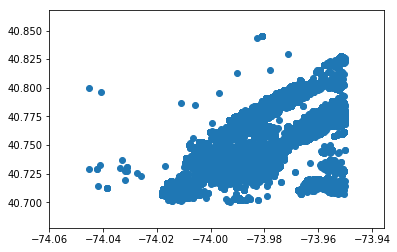

In [76]:
plt.scatter(low['longitude'],low['latitude'])

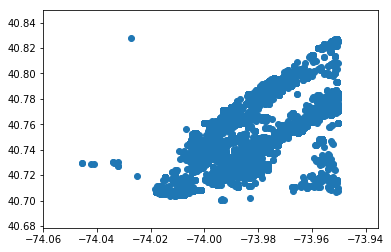

In [77]:
plt.scatter(med['longitude'],med['latitude'])

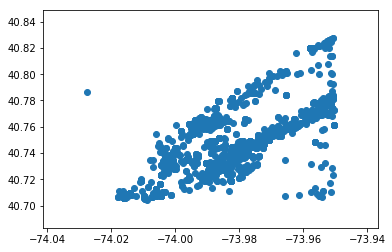

In [78]:
plt.scatter(high['longitude'],high['latitude'])

In [121]:
cv_scores = [] 
print fea_categorical
print fea_additional
print feature_params
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(train_X,train_y):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
    #import pdb;pdb.set_trace()
    print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
    importance_inx = np.argsort(model.feature_importances_*-1)
    print('Most important 40 features:')
    ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
    print(ff)
    print('-------------------------')
          
    #import pdb;pdb.set_trace()
    cv_scores.append(log_loss(val_y, preds))
    #print(cv_scores)
    #break
print 'mean score={}'.format(np.mean(cv_scores))

['building_id', 'manager_id', 'display_address', 'building_id_medium', 'building_id_high', 'manager_id_medium', 'manager_id_high']
['weekdays', 'manager_count', 'building_count', 'num_features', 'num_description_words', 'days', 'num_photos', 'created_month', 'created_day', 'created_hour']
{'nTextFea': 300, 'step_size': 0.02, 'nQuantLevel': 10, 'category_nfold': 3}


KeyboardInterrupt: 

In [111]:
cv_scores = [] 
print fea_categorical
print fea_additional
print feature_params
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(train_X,train_y):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
    #import pdb;pdb.set_trace()
    print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
    importance_inx = np.argsort(model.feature_importances_*-1)
    print('Most important 40 features:')
    ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
    print(ff)
    print('-------------------------')
          
    #import pdb;pdb.set_trace()
    cv_scores.append(log_loss(val_y, preds))
    #print(cv_scores)
    #break
print 'mean score={}'.format(np.mean(cv_scores))

['building_id', 'manager_id', 'display_address', 'building_id_medium', 'building_id_high', 'manager_id_medium', 'manager_id_high']
['weekdays', 'manager_count', 'building_count', 'num_features', 'num_description_words', 'days', 'num_photos', 'created_month', 'created_day', 'created_hour']
best iterations:3333, best_score=0.52764, last_score=0.527691281573
Most important 40 features:
[('price', 0.057805404), ('manager_id_medium', 0.051225908), ('manager_id_high', 0.049443644), ('listing_id', 0.048090525), ('latitude', 0.045347061), ('building_id_medium', 0.044876315), ('longitude', 0.043825347), ('building_id_high', 0.041964259), ('num_description_words', 0.041846026), ('manager_id', 0.03915073), ('days', 0.038719397), ('display_address', 0.036470763), ('address_num', 0.035605904), ('manager_count', 0.035509568), ('building_id', 0.033547759), ('building_count', 0.026727419), ('created_day', 0.026427455), ('price_quantile_lat_long', 0.026175661), ('created_hour', 0.024353983), ('num_phot

In [112]:
cv_scores = [] 
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(train_X,train_y):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB_sklearn(dev_X, dev_y, val_X, val_y,verbose=False)
    #import pdb;pdb.set_trace()
    print('best iterations:{}, best_score={}, last_score={}'.format(model.best_iteration,
                                                                   model.best_score,log_loss(val_y, preds)))
    importance_inx = np.argsort(model.feature_importances_*-1)
    print('Most important 40 features:')
    ff = [(fealist[x],model.feature_importances_[x]) for x in importance_inx[:40]]
    print(ff)
    print('-------------------------')
          
    #import pdb;pdb.set_trace()
    cv_scores.append(log_loss(val_y, preds))
    #print(cv_scores)
    #break
print 'mean score={}'.format(np.mean(cv_scores))

KeyboardInterrupt: 

In [122]:
preds, model = runXGB_sklearn(train_X, train_y, test_X,num_rounds=4000)
out_df = pd.DataFrame(preds)
out_df.columns = ["low", "medium", "high"]
out_df["listing_id"] = test_df.listing_id.values


In [123]:
import time
filename = time.asctime() +'_res.csv'
out_df.to_csv(filename, index=False)